<a href="https://colab.research.google.com/github/abdnass/Bank-Loan-Term-Pred/blob/main/DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy.linalg import norm, inv
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.datasets import make_regression
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


# Double Descent in Linear Regression model.

### Isotropic Gaussian Design matrix with noise
We are going to generate linear regression data $y = x^{T}w + \epsilon$, with $x\sim \mathcal{N}(0, I)$ and $\epsilon \sim \mathcal{N}(0, \sigma^{2})$

In [ ]:
## Functions
def risk(X, X_p, eps, sigma, Sigma, theta_star, P):
    n = X.shape[0]
    p = X_p.shape[1]
    d = Sigma.shape[0]

    # Generate the true labels
    y = X @ theta_star + eps

    # Calculate least-squares / min-norm solution
    theta_hat = np.zeros(d)
    if p >= n:
        theta_hat[P] = X_p.T @ inv(X_p @ X_p.T) @ y
    else:
        theta_hat[P] = inv(X_p.T @ X_p) @ X_p.T @ y

    theta_hat[np.setdiff1d(np.arange(d), P)] = 0

    # Compute the training/test risk
    R = np.mean((y - X @ theta_hat)**2)
    R_test = sigma**2 + (theta_hat - theta_star).T @ Sigma @ (theta_hat - theta_star)
    theta_norm = norm(theta_hat, 2)  # L_2 norm of parameter vector
    return R, R_test, theta_norm

## Theoretical risk functions
def theo_det(theta_star, sigma, p, n, Sigma):
    d = Sigma.shape[0]
    P = np.arange(p)
    if p <= n - 2:
        R = (norm(Sigma[np.ix_(np.setdiff1d(np.arange(d), P), np.setdiff1d(np.arange(d), P))]**0.5 @ theta_star[np.setdiff1d(np.arange(d), P)], 2)**2 + sigma**2) * (1 + p / (n - p - 1))
    elif n - 1 <= p <= n + 1:
        R = 1000  # infinity
    elif p >= n + 2 and p < d:
        R = norm(theta_star[P], 2)**2 * (1 - n / p) + (norm(theta_star[np.setdiff1d(np.arange(d), P)], 2)**2 + sigma**2) * (1 + n / (p - n - 1))
    elif p == d:
        R = norm(theta_star[P], 2)**2 * (1 - n / p) + sigma**2 * (1 + n / (p - n - 1))
    return R

def theo_rand(theta_star, sigma, p, n, d, Sigma):
    d = Sigma.shape[0]
    if p <= n - 2:
        R = ((1 - p / d) * norm(Sigma**0.5 @ theta_star, 2)**2 + sigma**2) * (1 + p / (n - p - 1))
    elif n - 1 <= p <= n + 1:
        R = 1000  # infinity
    elif p >= n + 2:
        R = norm(theta_star, 2)**2 * (1 - n / d * (2 - (d - n - 1) / (p - n - 1))) + sigma**2 * (1 + n / (p - n - 1))
    return R


In [ ]:

## Setting up parameters
n = 50 # number of training data points
d = 100  # dimension
M = 100  # number of Monte Carlo iterations
sigma = 1 / 5  # sd of the label noise
Sigma = np.eye(d)
theta_star = 1 / (np.arange(1, d+1))
theta_star = theta_star / norm(theta_star, 2)

In [ ]:
## Monte Carlo simulation
def MC_simulation(n, d, M, sigma, Sigma, risk):
    R = np.zeros((d, M))
    R_mean = np.zeros(d)
    R_test = np.zeros((d, M))
    R_test_mean = np.zeros(d)
    theta = np.zeros((d, M))
    theta_mean = np.zeros(d)

    for p in range(1, d + 1):
        for i in range(M):
            ## Sample new training data
            X = multivariate_normal.rvs(mean=np.zeros(d), cov=Sigma, size=n)
            if rnd == 1:
                P = np.random.choice(np.arange(d), p, replace=False)
            else:
                P = np.arange(p)

            X_p = X[:, P]

            ## Sample new label noise
            eps = np.random.normal(0, sigma, n)
            result = risk(X, X_p, eps, sigma, Sigma, theta_star, P)
            R[p-1, i] = result[0]
            R_test[p-1, i] = result[1]
            theta[p-1, i] = result[2]

        R_mean[p-1] = np.mean(R[p-1, :])
        R_test_mean[p-1] = np.mean(R_test[p-1, :])
        theta_mean[p-1] = np.mean(theta[p-1, :])

        ## Show progression for p
        if p % 10 == 0:
            print(f'Loading {p / d * 100:.0f} %')

    return R_mean, R_test_mean



Compute the theoritical values of the test error in both deteministic and random choice of the set of indices P.


In [ ]:
Theo_risk_deter = []
Theo_risk_rand = []
for p in range(d):
  Theo_risk_deter.append(theo_det(theta_star, sigma, p, n, Sigma))
  Theo_risk_rand.append(theo_rand(theta_star, sigma, p, n, d,  Sigma))

Deterministic choise of the set of indices P.

Loading 10 %
Loading 20 %
Loading 30 %
Loading 40 %
Loading 50 %
Loading 60 %
Loading 70 %
Loading 80 %
Loading 90 %
Loading 100 %


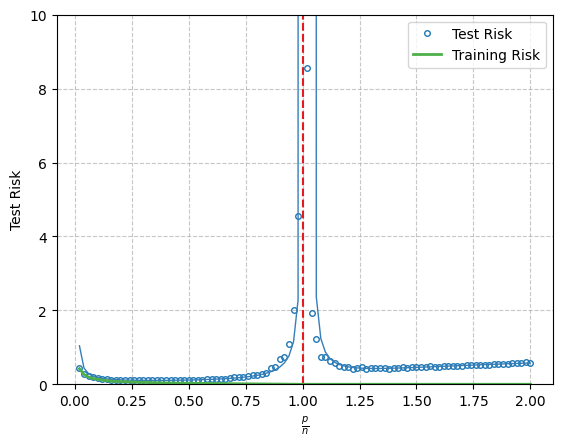

In [ ]:
rnd = 0  # random choice (rnd=1) or deterministic choice (rnd=0)
R_mean, R_test_mean = MC_simulation(n,d,M,sigma,Sigma, risk)
colors = plt.get_cmap('Set1')
plt.plot(np.arange(1, d + 1)/n, R_test_mean, marker = 'o', linestyle = 'None', markersize = '4',markerfacecolor='none', label='Test Risk')
plt.plot(np.arange(1,d+1)/n, Theo_risk_deter, color = colors(1), linewidth = 1)
plt.axvline(x=1, color=colors(0), linestyle = '--')
plt.plot(np.arange(1, d + 1)/n, R_mean, label='Training Risk', color=colors(2), linewidth=2)
plt.xlabel(r'$\frac{p}{n}$')
plt.ylabel('Test Risk')
plt.ylim(0, 10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('linear regression deterministic choise.pdf')
plt.show()


Random choise of the set P rnd = 1.

Loading 10 %
Loading 20 %
Loading 30 %
Loading 40 %
Loading 50 %
Loading 60 %
Loading 70 %
Loading 80 %
Loading 90 %
Loading 100 %


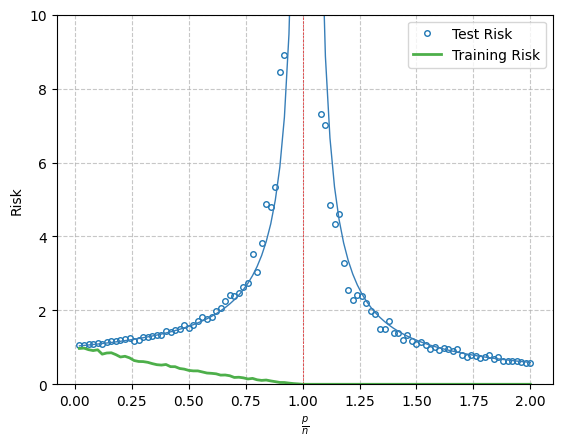

In [ ]:
rnd = 1  # random choice (rnd=1) or deterministic choice (rnd=0)
R_mean, R_test_mean = MC_simulation(n,d,M,sigma,Sigma, risk)

colors = plt.get_cmap('Set1')
plt.plot(np.arange(1, d + 1)/n, R_test_mean, marker = 'o', linestyle = 'None', markersize = '4',markerfacecolor='none', label='Test Risk')
plt.plot(np.arange(1,d+1)/n, Theo_risk_rand, color = colors(1), linewidth = 1)
plt.axvline(x=1, color=colors(0), linewidth=0.5, linestyle = '--')
plt.plot(np.arange(1, d + 1)/n, R_mean, label='Training Risk', color=colors(2), linewidth=2)
plt.xlabel(r'$\frac{p}{n}$')
plt.ylabel('Risk')
plt.ylim(0, 10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('linear regression random choise.pdf')
plt.show()


### Influence of the signal-to-noise ratio.
Here we fixe the true parameter to be normalized and use three different values for the noise $\sigma$, we will take $\sigma_{1} = \frac{1}{2}\sqrt{\frac{d}{d - n - 1}}, \sigma_{2} = \sqrt{\frac{d}{d - n - 1}}, \sigma_{3} = 2\sqrt{\frac{d}{d - n - 1}}$. and $n = 40$, $d = 120$.

In [ ]:
n = 25
d = 120
Sigma = np.eye(d)
theta_star = 1 / (np.arange(1, d+1))
theta_star = theta_star / norm(theta_star, 2)
rnd = 1
sigma = [1/2*np.sqrt(d/(d-n-1)), np.sqrt(d/(d-n-1)), 2*np.sqrt(d/(d-n-1))]
R = []
for sig in sigma:
    R.append(MC_simulation(n, d, M, sig, Sigma, risk))


Loading 8 %
Loading 17 %
Loading 25 %
Loading 33 %
Loading 42 %
Loading 50 %
Loading 58 %
Loading 67 %
Loading 75 %
Loading 83 %
Loading 92 %
Loading 100 %
Loading 8 %
Loading 17 %
Loading 25 %
Loading 33 %
Loading 42 %
Loading 50 %
Loading 58 %
Loading 67 %
Loading 75 %
Loading 83 %
Loading 92 %
Loading 100 %
Loading 8 %
Loading 17 %
Loading 25 %
Loading 33 %
Loading 42 %
Loading 50 %
Loading 58 %
Loading 67 %
Loading 75 %
Loading 83 %
Loading 92 %
Loading 100 %


In [ ]:
Theo_risk_deter = []
Theo_risk_rand = []

for sig in sigma:
  l = []
  m = []
  for p in range(d):
    l.append(theo_det(theta_star, sig, p, n, Sigma))
    m.append(theo_rand(theta_star, sig, p, n, d,  Sigma))
  Theo_risk_deter.append(l)
  Theo_risk_rand.append(m)

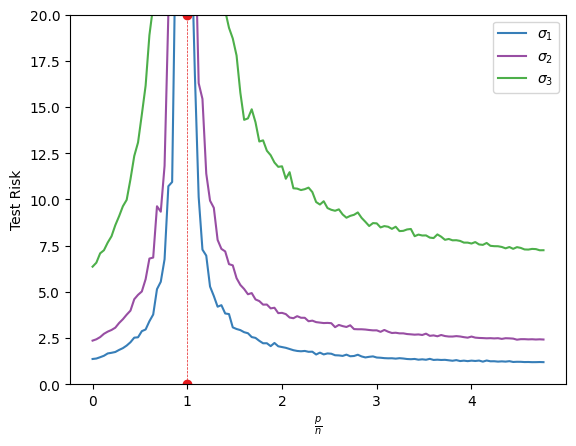

In [ ]:
colors = plt.get_cmap('Set1')
plt.plot(np.arange(0,d)/n, R[0][1], label = r'$\sigma_{1}$', color = colors(1))

plt.plot(np.arange(0,d)/n, R[1][1], label = r'$\sigma_{2}$', color = colors(3))

plt.plot(np.arange(0,d)/n, R[2][1], label = r'$\sigma_{3}$', color = colors(2))
plt.axvline(x=1, marker = 'o', color=colors(0), linewidth=0.5, linestyle = '--')
plt.xlabel(r'$\frac{p}{n}$')
plt.ylabel('Test Risk')
plt.ylim(0, 20)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Anisotropic Gaussian design matrix.
Next we look at the behavior of the test error in the case when the covarince matrix $\Sigma \neq I$.

We consider the case when the eigenvalues of the covariance matrix are proportional to $\frac{1}{k}$ for $k = \{1,..., d\}$.

In [ ]:
n = 50 # number of data points
d = 100# number of parameters
M = 100 #number of MC Iterations
sigma = 1
alpha = 1 # polynomial decay factor

Sigma1 = np.array([(i+1)**(-alpha) for i in range(d)])*np.eye(d,d)
Sigma2 = np.array([1/k for k in range(1, d+1)])*np.eye(d,d)
theta_star = 1 / (np.arange(1, d+1))
theta_star = theta_star / norm(theta_star, 2)


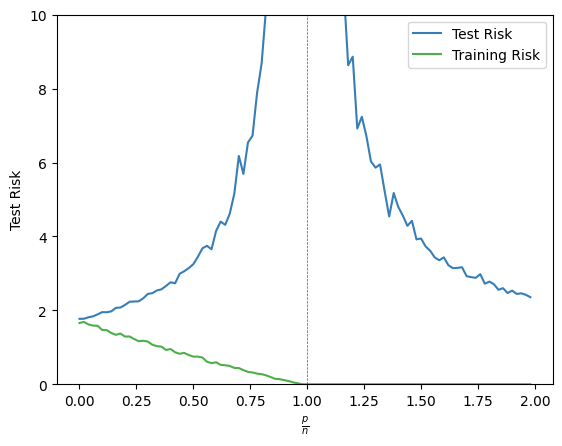

In [ ]:
# R_mean, R_test_mean = MC_simulation(n,d,M,sigma,Sigma2, risk)
# plots
colors = plt.get_cmap('Set1')
plt.plot(np.arange(0,d)/n, R_test_mean, color = colors(1), label = 'Test Risk')
plt.plot(np.arange(0,d)/n, R_mean, color = colors(2), label = 'Training Risk')
plt.ylim(0,10)
plt.axvline(x = 1, color = colors(0), linestyle = '--', linewidth = 0.5)
plt.ylabel('Test Risk')
plt.xlabel(r'$\frac{p}{n}$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Double Descent in Random Feature model.

In [ ]:
def RELU(x):
    return max(0, x)
def Sigmoid(x):
    return 1/(1 + np.exp(-x))

In [ ]:
n = 50 # number of data points
# d = 100
p = 200 #number of features
M = 100 #MC simulation
sigma = 1
eps = np.random.normal(0, sigma, n)

In [ ]:
def Variance(X, W ,eps ,theta_star, activation):
    n = np.shape(X)[0]
    p = np.shape(W)[0]
    # d = np.shape(X)[1]
    y = X@theta_star + eps
    Phi  = np.array([[activation(np.dot(X[j,:], W[k,:])) for k in range(p)] for j in range(n)])
    if p < n:
        theta_hat = np.linalg.inv(Phi.T@Phi)@Phi.T @ y
    else: theta_hat = Phi.T@np.linalg.inv(Phi@Phi.T) @ y

    variance = 0
    E_ = 0
    for k in range(n):
        E_ += np.dot((W@X[k,:]), theta_hat)
    E_ = E_/n
    for k in range(n):
        variance += (E_ - (W@X[k,:]).T@theta_hat)**2
    variance = variance/n
    CN = 0
    if n>p: GM = np.conj(Phi).T@Phi/n
    else: GM = Phi@np.conj(Phi).T/p
    CN = np.linalg.cond(GM)
    return variance, CN


In [ ]:
def Bias(X, W ,eps ,theta_star, activation):
    n= np.shape(X)[0]
    p = np.shape(W)[0]
    # d = np.shape(X)[1]
    y = X@theta_star + eps
    Phi  = np.array([[activation(np.dot(X[j,:], W[k,:])) for k in range(p)] for j in range(n)])
    if p < n:
        theta_hat = np.linalg.inv(Phi.T@Phi)@Phi.T @ y
    else: theta_hat = Phi.T@np.linalg.inv(Phi@Phi.T) @ y
    bias = 0
    E_ = 0
    for k in range(n):
        E_ += np.dot((W@X[k,:]), theta_hat)
    E_ = E_/n
    for k in range(n):
        bias += (y[k] - E_)**2
    bias = bias/n
    return bias

In [ ]:
def MC_simulationRF(n, p, d, M, sigma, activation, variance, Bias):
    V = np.zeros((p, M))
    B = np.zeros((p, M))
    V_mean = np.zeros(p)
    B_mean = np.zeros(p)
    CN = np.zeros((p, M))
    CN_mean = np.zeros(p)
    # theta_star = 1 / (np.arange(1, d+1))
    theta_star = np.random.uniform(0,1, d)
    theta_star = theta_star / norm(theta_star, 2)
    # theta = np.zeros((d, M))
    # theta_mean = np.zeros(d)

    for k in range(1, p + 1):
        for i in range(M):
            ## Sample new training data
            X = multivariate_normal.rvs(mean=np.zeros(d), size=n)
            ## Sample new weights
            W = multivariate_normal.rvs(mean=np.zeros(d), cov=1/d, size=k+1)

            ## Sample new label noise
            eps = np.random.normal(0, sigma, n)
            variance = Variance(X, W, eps, theta_star, activation)
            bais = Bias(X, W, eps, theta_star, activation)


            V[k-1, i] = variance[0]
            B[k-1, i] = bais
            CN[k-1, i] = variance[1]
            # theta[k-1, i] = result[2]

        V_mean[k-1] = np.mean(V[k-1, :])
        B_mean[k-1] = np.mean(B[k-1, :])
        CN_mean[k-1] = np.mean(CN[k-1, :])
        # theta_mean[p-1] = np.mean(theta[p-1, :])

        ## Show progress for p
        if k % 10 == 0:
            print(f'Loading {k / p * 100:.0f} %')

    return V_mean, B_mean, CN_mean


In [ ]:
d = [10, 20,30]
P_Relu = []
for i in d:
  P_Relu.append(MC_simulationRF(n, p, i, M, sigma, RELU, Variance, Bias))
# d =
# P = MC_simulationRF(n, p, d, M, sigma, RELU, Variance)

Loading 5 %
Loading 10 %
Loading 15 %
Loading 20 %
Loading 25 %
Loading 30 %
Loading 35 %
Loading 40 %
Loading 45 %
Loading 50 %
Loading 55 %
Loading 60 %
Loading 65 %
Loading 70 %
Loading 75 %
Loading 80 %
Loading 85 %
Loading 90 %
Loading 95 %
Loading 100 %
Loading 5 %
Loading 10 %
Loading 15 %
Loading 20 %
Loading 25 %
Loading 30 %
Loading 35 %
Loading 40 %
Loading 45 %
Loading 50 %
Loading 55 %
Loading 60 %
Loading 65 %
Loading 70 %
Loading 75 %
Loading 80 %
Loading 85 %
Loading 90 %
Loading 95 %
Loading 100 %
Loading 5 %
Loading 10 %
Loading 15 %
Loading 20 %
Loading 25 %
Loading 30 %
Loading 35 %
Loading 40 %
Loading 45 %
Loading 50 %
Loading 55 %
Loading 60 %
Loading 65 %
Loading 70 %
Loading 75 %
Loading 80 %
Loading 85 %
Loading 90 %
Loading 95 %
Loading 100 %


In [ ]:
d = [10, 20,30]
P_Relu = []
for i in d:
  P_Relu.append(MC_simulationRF(n, p, i, M, sigma, Relu, Variance, Bias))

Plot the variance and condition number of the ReLU activation function.
:

In [ ]:
colors = plt.get_cmap('Set1')

plt.plot(np.arange(0,p)/n, P_Relu[0][0], color = colors(0), marker = 'o', markersize = '4', markerfacecolor = 'none', label = 'The Variance for $d = 10$')
plt.plot(np.arange(0,p)/n, P_Relu[1][0], color = colors(1), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The Variance for $d = 20$')
plt.plot(np.arange(0,p)/n, P_Relu[2][0], color = colors(2), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The Variance for $d = 30$')
plt.plot(np.arange(0,p)/n, P_Relu[1][2]/20000, color = colors(3), marker = '^', markersize = '4',markerfacecolor = 'none', label = 'The condition number')
# plt.plot(np.arange(0,p)/n, P[1][1]/20000, color = colors(4), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The condition number for $d = 20$')
# plt.plot(np.arange(0,p)/n, P[2][1]/20000, color = colors(6), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The condition number for $d = 30$')
plt.ylim(0,200)
plt.axvline(x = 1, color = colors(0), linestyle = '--', linewidth = 0.5)
plt.xlabel(r'$\frac{p}{n}$', fontsize = 12)
plt.ylabel('Value', fontsize=12)
plt.title('The Variance and Condition Number vs. $p/n$', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.text(2.5, 155, 'Relu', fontsize=30, color='black')
plt.show()

NameError: name 'P_Relu' is not defined

Plot the Bias and condition number of the ReLU activation function.
:

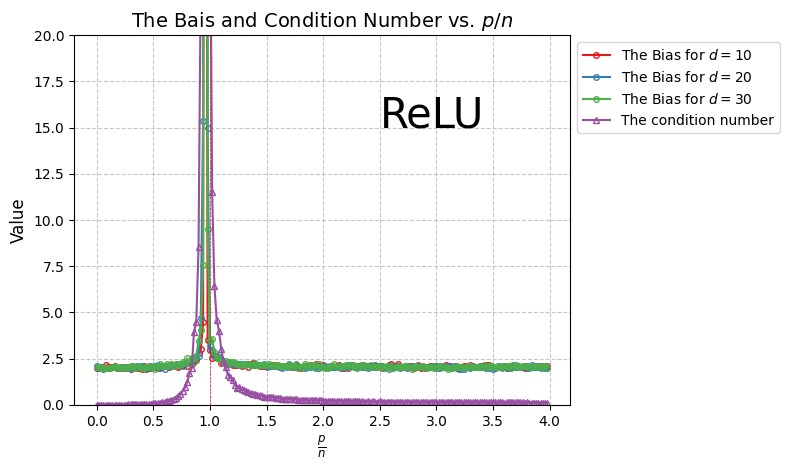

In [ ]:
colors = plt.get_cmap('Set1')

plt.plot(np.arange(0,p)/n, P_Relu[0][1], color = colors(0), marker = 'o', markersize = '4', markerfacecolor = 'none', label = 'The Bias for $d = 10$')
plt.plot(np.arange(0,p)/n, P_Relu[1][1], color = colors(1), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The Bias for $d = 20$')
plt.plot(np.arange(0,p)/n, P_Relu[2][1], color = colors(2), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The Bias for $d = 30$')
plt.plot(np.arange(0,p)/n, P_Relu[0][2]/20000, color = colors(3), marker = '^', markersize = '4',markerfacecolor = 'none', label = 'The condition number')
# plt.plot(np.arange(0,p)/n, P_Relu[1][1]/20000, color = colors(4), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The condition number for $d = 20$')
# plt.plot(np.arange(0,p)/n, P_Relu[2][1]/20000, color = colors(6), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The condition number for $d = 30$')
plt.ylim(0,20)
plt.axvline(x = 1, color = colors(0), linestyle = '--', linewidth = 0.5)
plt.xlabel(r'$\frac{p}{n}$', fontsize = 12)
plt.ylabel('Value', fontsize=12)
plt.title('The Bais and Condition Number vs. $p/n$', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.text(2.5, 15, 'ReLU', fontsize=30, color='black')
plt.show()

Plot the Variance and condition number of the Sigmoid activation function.

In [ ]:
d = [10, 20,30]
P_Sigmoid = []
for i in d:
  P_Sigmoid.append(MC_simulationRF(n, p, i, M, sigma, Sigmoid, Variance, Bias))

In [ ]:
colors = plt.get_cmap('Set1')

plt.plot(np.arange(0,p)/n, P_Sigmoid[0][0], color = colors(0), marker = 'o', markersize = '4', markerfacecolor = 'none', label = 'The Variance for $d = 10$')
plt.plot(np.arange(0,p)/n, P_Sigmoid[1][0], color = colors(1), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The Variance for $d = 20$')
plt.plot(np.arange(0,p)/n, P_Sigmoid[2][0], color = colors(2), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The Variance for $d = 30$')
plt.plot(np.arange(0,p)/n, P_Sigmoid[0][2]/200000, color = colors(3), marker = '^', markersize = '4',markerfacecolor = 'none', label = 'The condition number')
# plt.plot(np.arange(0,p)/n, P_Sigmoid[1][1]/20000, color = colors(4), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The condition number for $d = 20$')
# plt.plot(np.arange(0,p)/n, P_Sigmoid[2][1]/20000, color = colors(6), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The condition number for $d = 30$')
plt.ylim(0,200)
plt.axvline(x = 1, color = colors(0), linestyle = '--', linewidth = 0.5)
plt.xlabel(r'$\frac{p}{n}$', fontsize = 12)
plt.ylabel('Value', fontsize=12)
plt.title('The Variance and Condition Number vs. $p/n$', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.text(2.5, 15, 'Sigmoid', fontsize=30, color='black')

Plot the Bias and condition number of the Sigmoid activation function.

In [ ]:
colors = plt.get_cmap('Set1')

plt.plot(np.arange(0,p)/n, P_Sigmoid[0][1], color = colors(0), marker = 'o', markersize = '4', markerfacecolor = 'none', label = 'The Bias for $d = 10$')
plt.plot(np.arange(0,p)/n, P_Sigmoid[1][1], color = colors(1), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The Bias for $d = 20$')
plt.plot(np.arange(0,p)/n, P_Sigmoid[2][1], color = colors(2), marker = 'o', markersize = '4',markerfacecolor = 'none', label = 'The Bias for $d = 30$')
plt.plot(np.arange(0,p)/n, P_Sigmoid[0][2]/200000, color = colors(3), marker = '^', markersize = '4',markerfacecolor = 'none', label = 'The condition number')
plt.ylim(0,20)
plt.axvline(x = 1, color = colors(0), linestyle = '--', linewidth = 0.5)
plt.xlabel(r'$\frac{p}{n}$', fontsize = 12)
plt.ylabel('Value', fontsize=12)
plt.title('The Bais and Condition Number vs. $p/n$', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.text(2.5, 15, 'Sigmoid', fontsize=30, color='black')

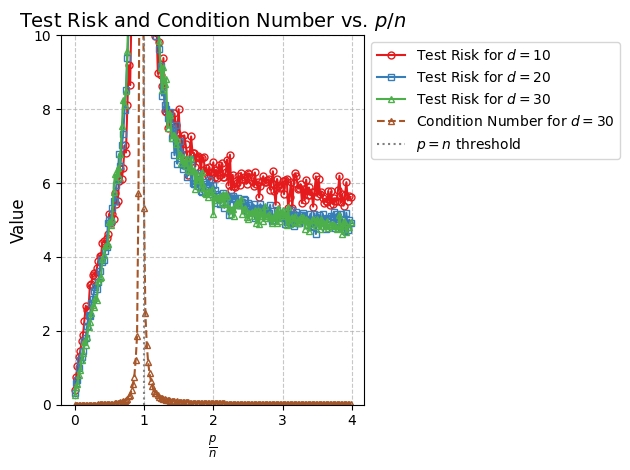

In [ ]:


colors = plt.get_cmap('Set1')


plt.plot(np.arange(0, p) / n, P[0][0], color=colors(0), marker='o', markersize=5, markerfacecolor='none',
         linestyle='-', linewidth=1.5, label=r'Test Risk for $d = 10$')
plt.plot(np.arange(0, p) / n, P[1][0], color=colors(1), marker='s', markersize=5, markerfacecolor='none',
         linestyle='-', linewidth=1.5, label=r'Test Risk for $d = 20$')
plt.plot(np.arange(0, p) / n, P[2][0], color=colors(2), marker='^', markersize=5, markerfacecolor='none',
         linestyle='-', linewidth=1.5, label=r'Test Risk for $d = 30$')

# Plot Condition Numbers with unique colors and distinct markers
# plt.plot(np.arange(0, p) / n, P[0][1] / 20000, color=colors(3), marker='o', markersize=5, markerfacecolor='none',
#          linestyle='--', linewidth=1.5, label=r'Condition Number for $d = 10$')
# plt.plot(np.arange(0, p) / n, P[1][1] / 20000, color=colors(4), marker='s', markersize=5, markerfacecolor='none',
#          linestyle='--', linewidth=1.5, label=r'Condition Number for $d = 20$')
plt.plot(np.arange(0, p) / n, P[2][1] / 20000, color=colors(6), marker='^', markersize=5, markerfacecolor='none',
         linestyle='--', linewidth=1.5, label=r'Condition Number for $d = 30$')


plt.axvline(x=1, color='gray', linestyle=':', linewidth=1.5, label=r'$p = n$ threshold')


plt.xlabel(r'$\frac{p}{n}$', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Test Risk and Condition Number vs. $p/n$', fontsize=14)
plt.ylim(0, 10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


### Epoch-wise double descent in linea regression.

In [ ]:
# theta_star = np.random.random(2)
# theta_star = theta_star / norm(theta_star, 2)
theta_star = [0.45,3]
sigma = 1
sigma1 = 1
sigma2 = 0.15
eta1 = 0.05
eta2 = 0.05
n = 10


In [ ]:
t = np.arange(0,10000)

In [ ]:
def U(t, sigma, sigma_i, eta_i, theta_star_i, n):
  u = sigma_i**2*(1-eta_i*sigma_i**2)**(2*t)*theta_star_i**2
  u += (sigma**2/n)*(1-(1-eta_i*sigma_i**2)**t)**2
  return u


In [ ]:
t = np.arange(0,10000)

In [ ]:
U1 = U(t, sigma, sigma1, 2*eta1, theta_star[0], n)
U2 = U(t, sigma, sigma2, 2*eta2, theta_star[1], n)
sum = U1+U2
argmin = np.argmin(sum)

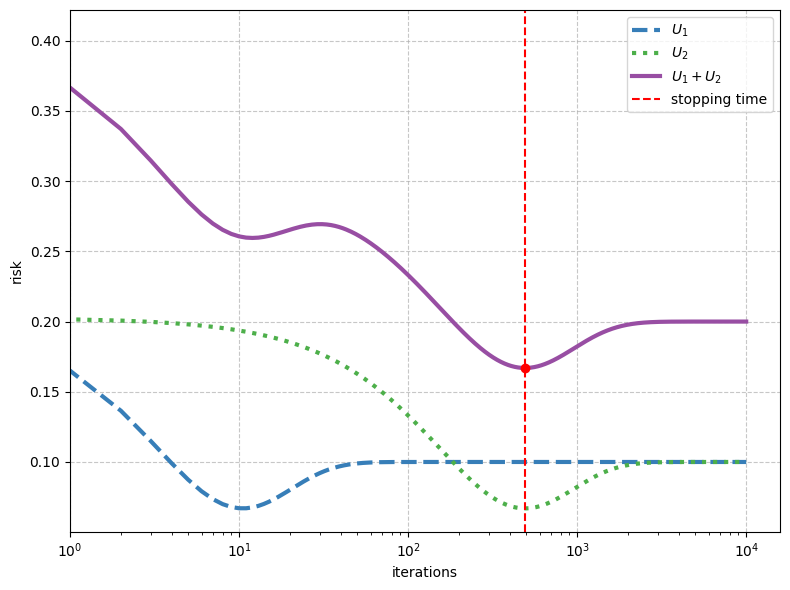

In [ ]:
line_style = ['--', ':', '-']
colors = plt.get_cmap('Set1')
plt.figure(figsize =(8,6))
ax = plt.subplot(111)
ax.set_xscale('log')
for risk , i, style in zip([U1,U2, U1+U2], range(3), line_style):
  ax.plot(t , risk, linestyle = style,color = colors(1+i), lw = 3)
ax.legend([r'$U_{1}$', r'$U_{2}$', r'$U_{1}+U_{2}$'])
ax.axvline(argmin, color = 'red', linestyle = '--')
plt.plot(argmin, sum[argmin - 1], 'ro', label = 'stopping time')
ax.set_xlabel('iterations')
ax.set_ylabel('risk')
ax.legend([r'$U_{1}$', r'$U_{2}$', r'$U_{1}+U_{2}$', 'stopping time'], bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
ax.set_xlim(1)

plt.tight_layout()
plt.show()

## We choose the step_size to satisfy (26) form the thesis. $\eta_{i} = \frac{1}{\sigma_{i}^{2}}\left(1 - \left(\frac{\frac{\sigma^{2}}{n}}{\sigma_{i}^{2}(\theta^{*})^{2} + \frac{\sigma^{2}}{n}}\right)^{\frac{1}{{t}}}\right)$, with t being the optimal stopping time.

In [ ]:
eta_opt1 = 1/(sigma1**2)*(1 - ((sigma**2/n)/(sigma1**2*theta_star[0]**2 + sigma**2/n))**(1/argmin))
eta_opt2 = 1/(sigma2**2)*(1 - ((sigma**2/n)/(sigma2**2*theta_star[1]**2 + sigma**2/n))**(1/argmin))


In [ ]:
U1 = U(t, sigma, sigma1, eta_opt1, theta_star[0], n)
U2 = U(t, sigma, sigma2, eta_opt2, theta_star[1], n)
sum = U1 + U2

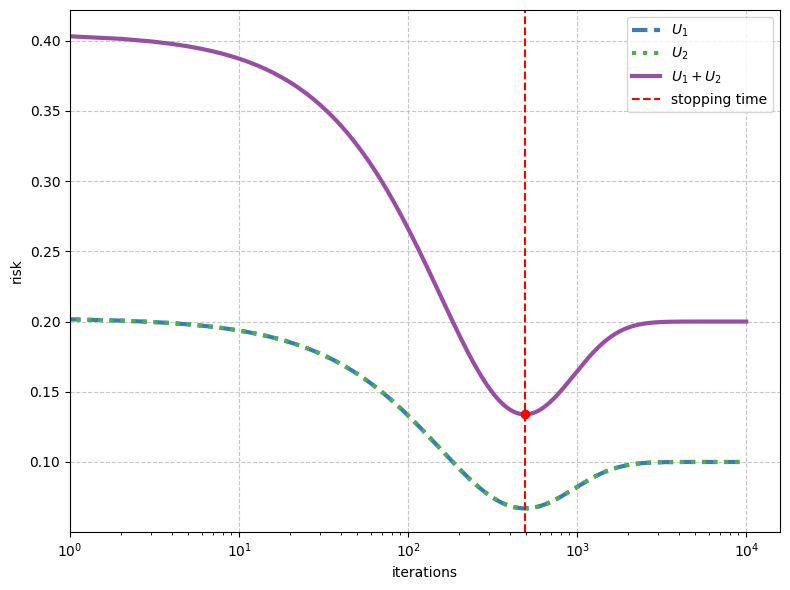

In [ ]:
line_style = ['--', ':', '-']
colors = plt.get_cmap('Set1')
plt.figure(figsize =(8,6))
ax = plt.subplot(111)
ax.set_xscale('log')
for risk , i, style in zip([U1,U2, U1+U2], range(3), line_style):
  ax.plot(t , risk, linestyle = style,color = colors(1+i), lw = 3)
ax.axvline(argmin, color = 'red', linestyle = '--')
plt.plot(argmin, sum[argmin - 1], 'ro')
ax.set_xlim(1)
ax.set_xlabel('iterations')
ax.set_ylabel('risk')
ax.legend([r'$U_{1}$', r'$U_{2}$', r'$U_{1}+U_{2}$', 'stopping time'], bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### DD in finite width neural networks.

In this experiment, we follow the setup from the paper Reconciling modern machine learning practice
and the bias-variance trade-of (https://arxiv.org/pdf/1812.11118)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector as p2v

class FCNN(nn.Module):
    def __init__(self, n_hidden, previous_model=None):
        super(FCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, n_hidden),
            nn.ReLU()
        )
        self.classifier = nn.Linear(n_hidden, 10)  # Output layer
        self.softmax = nn.Softmax(dim=1)

        # Initialize weights
        self._initialize_weights(previous_model)

    def _initialize_weights(self, previous_model):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if previous_model is None:
                    # Xavier initialization for the smallest model
                    nn.init.xavier_normal_(m.weight, gain = 1)
                    nn.init.constant_(m.bias, 0)
                else:
                    # Standard normal initialization for larger models
                    nn.init.normal_(m.weight, mean=0.0, std=0.1)
                    nn.init.constant_(m.bias, 0)

        # Reuse weights from the previous model if it exists
        if previous_model is not None and previous_model.features[1].out_features < 37:
            with torch.no_grad():
                # Reuse weights for the features layer
                old_features_weight = previous_model.features[1].weight
                old_features_bias = previous_model.features[1].bias
                new_features_weight = self.features[1].weight
                new_features_bias = self.features[1].bias

                # Handle weight and bias dimension mismatches
                new_features_weight[:old_features_weight.size(0), :old_features_weight.size(1)] = old_features_weight
                new_features_bias[:old_features_bias.size(0)] = old_features_bias

                # Reuse weights for the classifier layer
                old_classifier_weight = previous_model.classifier.weight
                old_classifier_bias = previous_model.classifier.bias
                new_classifier_weight = self.classifier.weight
                new_classifier_bias = self.classifier.bias

                new_classifier_weight[:old_classifier_weight.size(0), :old_classifier_weight.size(1)] = old_classifier_weight
                new_classifier_bias[:old_classifier_bias.size(0)] = old_classifier_bias

    def forward(self, x):
        out = self.features(x)
        out = self.classifier(out)
        out = self.softmax(out) # Apply softmax activation
        return out

# Data loading and preprocessing (using a subset of MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

subset_size = 3000
train_subset_indices = np.random.choice(len(trainset), subset_size, replace=False)
test_subset_indices = np.random.choice(len(testset), 4000, replace=False)


small_trainset = Subset(trainset, train_subset_indices)
small_testset = Subset(testset, test_subset_indices)

small_trainloader = torch.utils.data.DataLoader(small_trainset, batch_size=64, shuffle=True)
small_testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
# Training and evaluation function with weight reuse
def train_and_evaluate_with_weight_reuse(previous_model, width, epochs):
    model = FCNN(width, previous_model).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
    criterion = nn.MSELoss()

    # One-hot encode targets for MSE loss
    def one_hot_encode(targets, num_classes=10):
        return torch.eye(num_classes)[targets].to(device)

    # Training loop
    model.train()
    train_loss = 0
    for epoch in range(epochs):
        for images, labels in small_trainloader:
            labels = one_hot_encode(labels)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()


    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(small_testloader):
            targets = one_hot_encode(targets)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # test_loss += loss
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.argmax(1)).sum().item()

    return model, train_loss/(batch_idx +1), test_loss/(batch_idx+1)


# Analyze double descent with weight reuse
epochs = 1000
# widths = [1, 3, 5, 7, 9, 10, 20, 30, 40, 45, 47, 49, 50, 51, 53, 55, 60, 70, 80, 90, 100, 110, 130, 150, 170, 200, 250]
widths = [1, 3, 5, 7, 9, 10, 20, 25, 30 , 35, 37, 38, 39, 40, 50, 60, 70, 100]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses, test_losses = [], []
previous_model = None

for width in widths:
    print(f"Training with width: {width}")
    model, train_loss, test_loss = train_and_evaluate_with_weight_reuse(previous_model, width, epochs)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    previous_model = model  # Reuse the trained model for the next width
print('finished training')


In [ ]:
plt.figure(figsize=(12, 6))

# Plot Loss
# plt.subplot(1, 2, 1)
# plt.plot(hidden_units, test_accuracies, label='Train Loss', marker='o')
plt.plot(num_params, test_losses, label='Test Loss', marker='o')
plt.axvline(x = 30000, linestyle = '--', color = 'red')

plt.xlabel('Number of Hidden Units (log scale)')
plt.ylabel('Loss')
plt.title('Double Descent: Loss vs Number of Features')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

###Mitigating Double Descent.
In the following, we are going to use the $\ell_2$-regularization technique to mitigate and eliminate the double descent.

In [ ]:
def ell2risk(X, X_p, eps, sigma, Sigma, theta_star, P, lmbda):
    n = X.shape[0]
    p = X_p.shape[1]
    d = Sigma.shape[0]
    I = np.eye(p)
    I2 = np.eye(n)
    # Generate the true labels
    y = X @ theta_star + eps

    # Calculate least-squares / min-norm solution
    theta_hat = np.zeros(d)
    if p >= n:
        theta_hat[P] = X_p.T @ inv(X_p @ X_p.T + lmbda*I2) @ y
    else:
        theta_hat[P] = inv(X_p.T @ X_p + lmbda*I) @ X_p.T @ y

    theta_hat[np.setdiff1d(np.arange(d), P)] = 0

    # Compute the training/test risk
    R = np.mean((y - X @ theta_hat)**2)
    R_test = sigma**2 + (theta_hat - theta_star).T @ Sigma @ (theta_hat - theta_star)
    theta_norm = norm(theta_hat, 2)  # L_2 norm of parameter vector
    return R, R_test

In [ ]:
def MCRegularization(n, d, M, sigma, Sigma, risk):
    diff_lmbd = np.array([10**-3, 10**-2, 10**-1, 0, 1, 10, 100])

    t = len(diff_lmbd)
    R = np.zeros((d, M))
    R_mean = np.zeros((t,d))
    R_test = np.zeros((d, M))
    R_test_mean = np.zeros((t, d))
    lmbda_opt = np.zeros(d)

    for k in range(t):
      for p in range(1, d+1):

        # sigma_hat = sigma**2 + (d-p)*np.linalg.norm(theta_star)**2/d
        # lmbda_opt[p-1] = d**2*sigma_hat*np.linalg.norm(theta_star)**2/p
        # lmbda_opt[p-1] = sigma**2*p/(n*np.linalg.norm(theta_star)**2)
        lmbda_opt[p-1] = p*sigma**2 #optimal lambda for anisotropic features

        for i in range(M):
            ## Sample new training data
            X = multivariate_normal.rvs(mean=np.zeros(d), cov=Sigma, size=n)
            if rnd == 1:
                P = np.random.choice(np.arange(d), p, replace=False)
            else:
                P = np.arange(p)

            X_p = X[:, P]

            ## Sample new label noise
            eps = np.random.normal(0, sigma, n)
            result = ell2risk(X, X_p, eps, sigma, Sigma, theta_star, P, diff_lmbd[k]*lmbda_opt[p-1])
            R[p-1, i] = result[0]
            R_test[p-1, i] = result[1]


        R_mean[k][p-1] = np.mean(R[p-1, :])
        R_test_mean[k][p-1] = np.mean(R_test[p-1, :])

          ## Show progression for p
        # if p % 10 == 0:
        #     print(f'Loading {p / d * 100:.0f} %')


    return R_mean, R_test_mean




In [ ]:
n = 50 # number of data points
d = 100# number of parameters
M = 40 #number of MC Iterations
sigma = 1/3
rnd = 0
Sigma = np.eye(d)
theta_star = np.random.random(d)
theta_star = theta_star / norm(theta_star, 2)

In [ ]:
R, T = MCRegularization(n, d, M, sigma, Sigma, ell2risk)

In [ ]:
cmap = plt.get_cmap('Dark2')
# colorList = [cmap(10), cmap(30), cmap(90), 'blue','green',cmap(300),cmap(500)]
plt.figure(figsize = (10,6))
ax = plt.subplot(111)
for i in range(R.shape[0]):
  if i == 3 or i == 4: linewidth = 2.8
  else: linewidth = 1
  ax.plot(np.arange(0,d)/n, T[i], color = cmap(i), linestyle = '-', linewidth = linewidth, marker = 'o', markersize = 1.5)
  ax.set_ylim(0,10)
ax.legend([r'$\lambda = 10^{-5}\lambda_{opt}$', r'$\lambda = 10^{-3}\lambda_{opt}$', r'$\lambda = 10^{-1}\lambda_{opt}$', r'$\lambda = 0$', r'$\lambda = \lambda_{opt}$', r'$\lambda = 10\lambda_{opt}$', r'$\lambda = 100\lambda_{opt}$'])
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel(r'$\frac{p}{n}$', fontsize = 12)
ax.set_ylabel('risk', fontsize=12)
ax.set_title('Test Risk vs. $p/n$', fontsize=14)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.show()


In many real world problems, the eigenvalues of $\Sigma$ decay exponentially or follow a power law.

In [ ]:
eigenvalues = np.exp(-np.linspace(0, 5, d))

In [ ]:
# Sigma = np.eye(d)*eigenvalues
Q = np.linalg.qr(np.random.randn(d, d))[0]  # Random orthogonal matrix
Sigma = Q @ np.diag(eigenvalues) @ Q.T

In [ ]:
R, T = MCRegularization(n,d, M, sigma, Sigma, ell2risk)

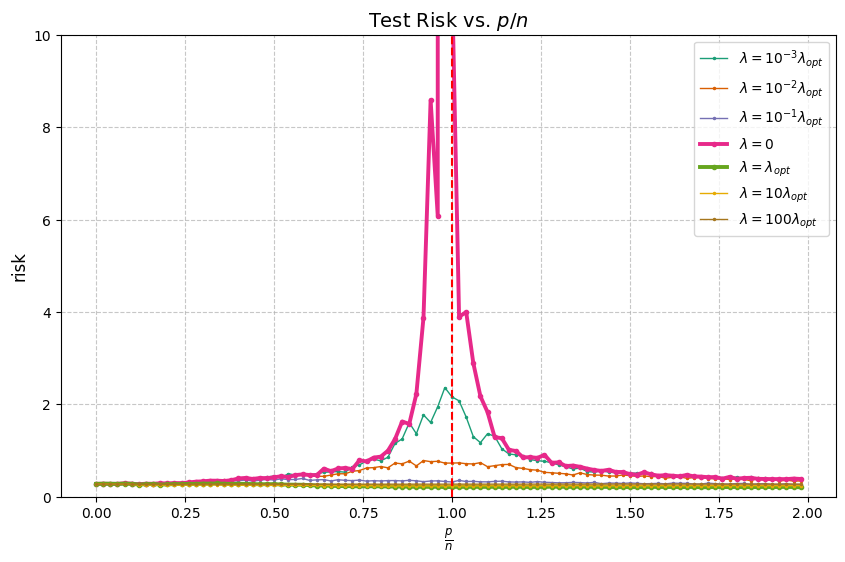

In [ ]:
cmap = plt.get_cmap('Dark2')
# colorList = [cmap(10), cmap(30), cmap(90), 'blue','green',cmap(300),cmap(500)]
plt.figure(figsize = (10,6))
ax = plt.subplot(111)
for i in range(TimeoutError.shape[0]):
  if i == 3 or i == 4:
      linewidth = 2.8
      markersize = 3
  else:
     linewidth = 1
     markersize = 1.5
  ax.plot(np.arange(0,d)/n, T[i], color = cmap(i), linestyle = '-', linewidth = linewidth, marker = 'o', markersize = markersize)
  ax.set_ylim(0,10)
ax.legend([r'$\lambda = 10^{-3}\lambda_{opt}$', r'$\lambda = 10^{-2}\lambda_{opt}$', r'$\lambda = 10^{-1}\lambda_{opt}$', r'$\lambda = 0$', r'$\lambda = \lambda_{opt}$', r'$\lambda = 10\lambda_{opt}$', r'$\lambda = 100\lambda_{opt}$'])
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel(r'$\frac{p}{n}$', fontsize = 12)
ax.set_ylabel('risk', fontsize=12)
ax.set_title('Test Risk vs. $p/n$', fontsize=14)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.show()


In [ ]:
def ell2riskRF(Phi, Phi_p, eps, sigma, Sigma, theta_star, P, lmbda):

    n = Phi.shape[0]
    p = Phi.shape[1]
    k = Phi_p.shape[1]
    # d = Sigma.shape[0]
    I = np.eye(k)
    I2 = np.eye(n)
    # Generate the true labels
    y = Phi @ theta_star + eps

    # Calculate least-squares / min-norm solution
    theta_hat = np.zeros(p)
    if k >= n:
        theta_hat[P] = Phi_p.T @ inv(Phi_p @ Phi_p.T + lmbda*I2) @ y
    else:
        theta_hat[P] = inv(Phi_p.T @ Phi_p + lmbda*I) @ Phi_p.T @ y

    theta_hat[np.setdiff1d(np.arange(p), P)] = 0

    # Compute the training/test risk
    R = np.mean((y - Phi @ theta_hat)**2)
    R_test = sigma**2 + (theta_hat - theta_star).T @ (theta_hat - theta_star)
    return R, R_test

In [ ]:
from math import e
def MCRegularizationRF(n, d, p, M, sigma, Sigma, activation, risk):
    diff_lmbd = np.array([10**-3, 10**-2, 10**-1, 0, 1, 10,100])
    # diff
    t = len(diff_lmbd)
    R = np.zeros((p, M))
    R_mean = np.zeros((t,p))
    R_test = np.zeros((p, M))
    R_test_mean = np.zeros((t, p))
    lmbda_opt = np.zeros(p)

    for k in range(len(diff_lmbd)):
      for l in range(1, p+1):

        # sigma_hat = sigma**2 + (d-p)*np.linalg.norm(theta_star)**2/d
        # lmbda_opt[p-1] = d**2*sigma_hat*np.linalg.norm(theta_star)**2/p
        # lmbda_opt[p-1] = sigma**2*p/(n*np.linalg.norm(theta_star)**2)
        lmbda_opt[l-1] = l*sigma**2



        for i in range(M):
            ## Sample new training data
            X = multivariate_normal.rvs(mean=np.zeros(d), cov = Sigma, size=n)
            W = multivariate_normal.rvs(mean = np.zeros(d), cov = 1/d, size = p)
            Phi = np.array([[activation(np.dot(X[r,:], W[s, :])) for s in range(p)] for r in range(n)])
            P = np.arange(l)
            Phi_p = Phi[:, P]

            ## Sample new label noise
            eps = np.random.normal(0, sigma, n)
            result = risk(Phi, Phi_p, eps, sigma, Sigma, theta_star, P, diff_lmbd[k]*lmbda_opt[l-1])
            R[l-1, i] = result[0]
            R_test[l-1, i] = result[1]


        R_mean[k][l-1] = np.mean(R[l-1, :])
        R_test_mean[k][l-1] = np.mean(R_test[l-1, :])
          ## Show progression for p
      print(k+1, 'out of ', len(diff_lmbd))


    return R_mean, R_test_mean





In [ ]:
n = 50 # number of data points
d = 10# number of parameters
p = 100
M = 2 #number of MC Iterations
sigma = 1
Sigma = np.eye(d)
theta_star = np.random.random(p)
theta_star = theta_star / norm(theta_star, 2)

In [ ]:
R,T = MCRegularizationRF(n, d, p, 5, sigma, Sigma, RELU, ell2riskRF)

1 out of  7
2 out of  7
3 out of  7
4 out of  7
5 out of  7
6 out of  7
7 out of  7


In [ ]:
cmap = plt.get_cmap('Dark2')
# colorList = [cmap(10), cmap(30), cmap(90), 'blue','green',cmap(300),cmap(500)]
plt.figure(figsize = (10,6))
ax = plt.subplot(111)
for i in range(T.shape[0]):
  if i == 3 or i == 4:
    linewidth = 2.8
    markersize = 3
  else:
     linewidth = 1
     markersize = 1.5
  ax.plot(np.arange(0,p)/n, T[i], color = cmap(i), linestyle = '-', linewidth = linewidth, marker = 'o', markersize = markersize)
  # ax.set_ylim(0,10)
ax.legend([r'$\lambda = 10^{-3}\lambda_{opt}$', r'$\lambda = 10^{-2}\lambda_{opt}$', r'$\lambda = 10^{-1}\lambda_{opt}$', r'$\lambda = 0$', r'$\lambda = \lambda_{opt}$', r'$\lambda = 10\lambda_{opt}$', r'$\lambda = 100\lambda_{opt}$'])
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel(r'$\frac{p}{n}$', fontsize = 12)
ax.set_ylabel('risk', fontsize=12)
ax.set_title('Test Risk vs. $p/n$', fontsize=14)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.show()

Mitigate the double descent in random fourier feature model.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# One-hot encode function
def one_hot_encode(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

class FourierFeatureModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FourierFeatureModel, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim, bias=False)
        # Random weight initialization from a normal distribution
        self.fourier_weights = nn.Parameter(
            torch.nn.init.normal_(self.hidden.weight, mean = 0.0, std = 1/5), requires_grad=False
        )

        # Output layer (real and imaginary components)
        self.output_layer = nn.Linear(hidden_dim , output_dim, bias=False)

    def forward(self, x):
        """
        Forward pass of the Fourier Feature Model.
        """
        # Compute projection: Wx
        projection = torch.matmul(x, self.fourier_weights.T)

        # Apply Fourier transformation: exp(-ix) = cos(x) - i*sin(x)
        real_part = torch.cos(projection)
        # imag_part = -torch.sin(projection)  # Negative sign for exp(-ix)

        # Concatenate real and imaginary parts
        # fourier_features = torch.cat([real_part, imag_part], dim=-1)
        # fourier_feature = real_part + imag_part

        # Pass through the output layer
        output = self.output_layer(real_part)

        return output


# Define MNIST dataset with noise
transform1 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.3)  # Adding Gaussian noise
])
# Data Preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Reduce dataset for faster experimentation
train_subset_indices = np.random.choice(len(trainset), 1000, replace=False)
test_subset_indices = np.random.choice(len(testset), 1000, replace=False)
trainset = Subset(trainset, train_subset_indices)
testset = Subset(testset, test_subset_indices)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Experiment Parameters
input_dim = 28 * 28  # Flattened MNIST input
output_dim = 10 # Number of classes
# hidden_units = [100, 200, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 20000, 40000, 60000]
hidden_units = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 2000, 4000, 6000]  # Varying num_hidden
num_epochs = 600
learning_rate = 0.01
momentum = 0.95
reg_params = [0, 0.001, 0.01, 0.1, 1, 10]
# Results storage
param_test_losses = []
# Experiment
for param in reg_params:
    train_losses = []
    test_losses = []
    print('Regularization parameter ', param)
    for num_hidden in hidden_units:
        print(f"Training model with {num_hidden} hidden units...")
        model = FourierFeatureModel(input_dim, num_hidden, output_dim).to(device)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        criterion = nn.MSELoss()
        # criterion = nn.CrossEntropyLoss()

        # Training loop
        trian_losses =[]

        model.train()
        for epoch in range(num_epochs):
            train_loss = 0
            for images, labels in trainloader:
                labels_one_hot = one_hot_encode(labels).to(device)
                # labels = labels.to(device)
                images = images.view(images.size(0), -1).to(device)  # Flatten images
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels_one_hot) + param * model.l2_regularization()
                loss.backward()
                optimizer.step()

        # Evaluate
        # model.eval()
        # train_loss = 0
        test_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            # for images, labels in trainloader:
            #     # labels_one_hot = one_hot_encode(labels).to(device)
            #     labels = labels.to(device)
            #     images = images.view(images.size(0), -1).to(device)
            #     outputs = model(images)
            #     loss = criterion(outputs, labels_one_hot)
            #     train_loss += loss.item()

            for images, labels in testloader:
                labels_one_hot = one_hot_encode(labels).to(device)
                # labels = labels.to(device)
                images = images.view(images.size(0), -1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels_one_hot)
                test_loss += loss.item()
                # _, predicted = torch.max(outputs, 1)
                # total += labels.size(0)
                # correct += (predicted == labels).sum().item()

        # train_loss /= len(trainloader)
        test_loss /= len(testloader)
        # test_loss = correct//total
        # train_losses.append(train_loss)
        test_losses.append(test_loss)
    param_test_losses.append(test_losses)

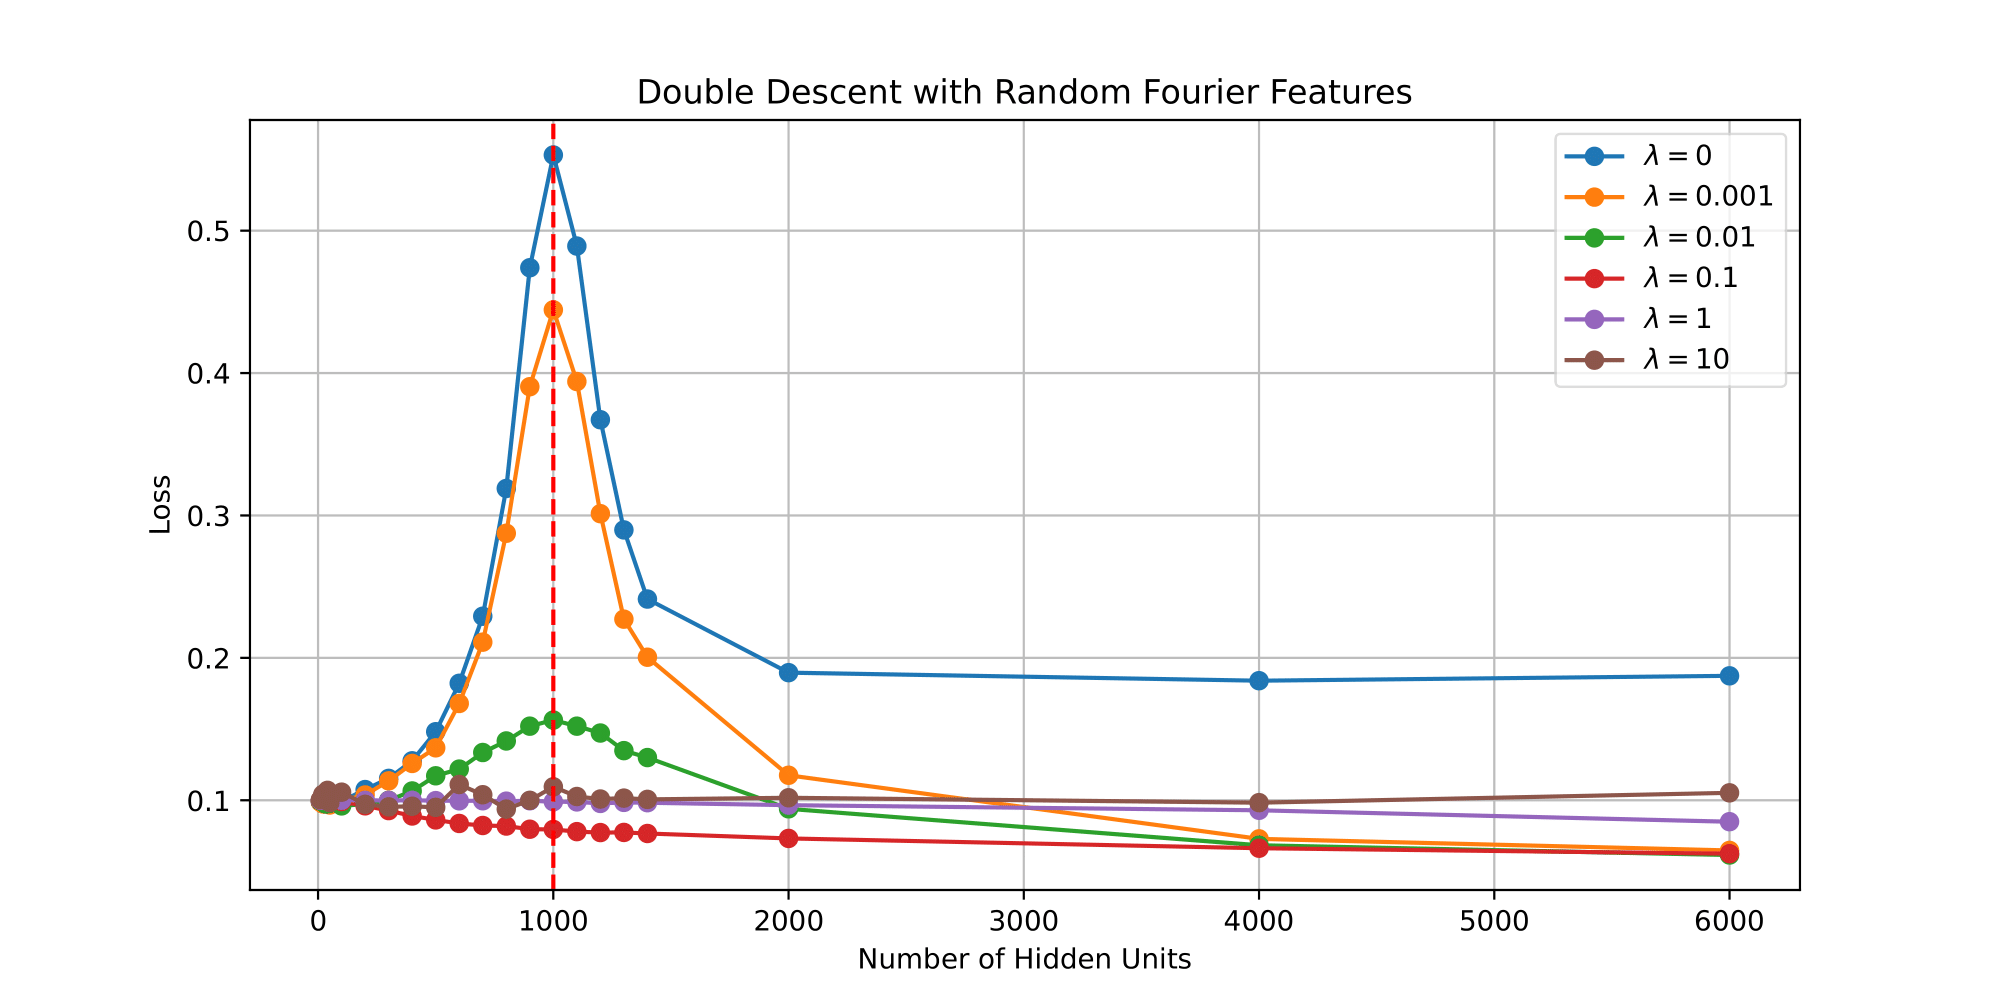

In [9]:
plt.figure(figsize=(11, 7))
colors = plt.get_cmap('tab10')
# plt.plot(hidden_units, train_losses, label='Train Loss', marker='o')
for i in range(len(reg_params)):
    plt.plot(hidden_units, param_test_losses[i], label='Test Loss', marker='o', color = colors(i)
    )
# plt.plot(10*np.array(hidden_units), train_losses, label='Test Loss', marker='o')
plt.xlabel('Number of features')
plt.axvline(x = 1000, linestyle = '--', color = 'red')
plt.ylabel('Loss')
plt.title('Double Descent in Random Fourier Features')
plt.legend([r'$\lambda = 0$',r'$\lambda = 0.001$', r'$\lambda = 0.01$', r'$\lambda = 0.1$', r'$\lambda = 1$', r'$\lambda = 10$'])
plt.grid(True)
plt.savefig('RFF regularization.pdf')
plt.show()